___
___
# **Proyecto Final Data Science**
## **Analisis Exploratorio de Datos**

Equipo: 2 - Quantum Insights
Integrantes:
- Felipe Varela - Product Owner
- Freddy Yaquive - Data Scientist
- Ivan Martinez - Data Scientist
- Sebastian Moya - Data Scientist
- Nicolás Lazarte - Scrum Master

Cohorte: DSFT01

Objetivo: Comprender la naturaleza de los datos, detectar anomalías y 
           evaluar la viabilidad de los modelos de recomendación.

___
___

In [132]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import r2_score
# Importar librerías de Scikit-Learn 
from sklearn.feature_extraction.text import TfidfVectorizer # Para convertir texto a números
from sklearn.metrics.pairwise import linear_kernel           # Para calcular similitud del coseno eficientemente


___
### **1. Carga de los conjuntos de datos**

In [133]:
# Cargamos cada archivo CSV en un DataFrame de pandas para poder manipularlos como tablas de datos
df_events = pd.read_csv("databases/events.csv")
df_order_items = pd.read_csv("databases/order_items.csv")
df_orders = pd.read_csv("databases/orders.csv")
df_products = pd.read_csv("databases/products.csv")
df_reviews = pd.read_csv("databases/reviews.csv")
df_users = pd.read_csv("databases/users.csv")

In [134]:
df_events.head()

,event_id,user_id,product_id,event_type,event_timestamp
0,E00000001,U009798,P001393,cart,2025-07-08T14:28:55.893919
1,E00000002,U005881,P000669,view,2025-10-19T23:00:44.067982
2,E00000003,U006348,P001404,view,2025-05-09T07:02:42.256662
3,E00000004,U002664,P000400,cart,2025-07-19T22:47:07.019634
4,E00000005,U005776,P000392,view,2024-10-24T10:20:33.602165


In [135]:
df_order_items.head()

,order_item_id,order_id,product_id,user_id,quantity,item_price,total_price
0,I00000001,O00000001,P001758,U009310,2,1650,3300
1,I00000002,O00000001,P001119,U009310,1,1550,1550
2,I00000003,O00000001,P001794,U009310,1,1750,1750
3,I00000004,O00000001,P001038,U009310,1,4350,4350
4,I00000005,O00000002,P000859,U003247,1,1400,1400


In [136]:
df_orders.head()

,order_id,user_id,order_date,order_status,total_amount
0,O00000001,U009310,9/09/2025 14:52,processing,10950
1,O00000002,U003247,15/04/2025 1:18,completed,11230
2,O00000003,U007252,27/04/2025 15:37,processing,39594
3,O00000004,U008986,4/10/2025 20:35,cancelled,22250
4,O00000005,U008537,13/11/2024 8:15,cancelled,14490


___
### **2. Ajustes en la tabla de Productos**

Ajustar nombres de columnas y eliminar artefactos de índice para asegurar consistencia en los cruces (Joins).

In [137]:
# Renombrar la columna 'rating' a 'rating_product' para evitar ambigüedades cuando unamos esta tabla con 'reviews'
df_products = df_products.rename(columns={"rating": "rating_product"})

# Eliminar la columna 'Unnamed: 0', que suele aparecer cuando se guarda un archivo CSV incluyendo el índice previo
df_products = df_products.drop(columns=["Unnamed: 0"], axis=1)

# Validar el DataFrame resultante para confirmar los cambios
df_products.head()

,product_id,rating_product,ProductName,Brand,Price,Image_Url,Category,SubCategory
0,P000001,4.08,Onion (Loose),Fresho,69.75,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
1,P000002,3.87,Onion,Fresho,174.35,https://www.bigbasket.com/media/uploads/p/l/12...,Fruits & Vegetables,"Potato, Onion & Tomato"
2,P000003,3.46,"Farm Eggs - Table Tray, Medium, Antibiotic Res...",Fresho,110.00,https://www.bigbasket.com/media/uploads/p/l/40...,"Eggs, Meat & Fish",Farm Eggs
3,P000004,4.14,Potato (Loose),Fresho,50.32,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"
4,P000005,3.97,Potato,Fresho,100.65,https://www.bigbasket.com/media/uploads/p/l/40...,Fruits & Vegetables,"Potato, Onion & Tomato"


In [138]:
df_reviews.head()

,review_id,order_id,product_id,user_id,rating,review_text,review_date
0,R00000528,O00000237,P001326,U001094,2,Color was different from images.,2025-10-14T12:03:56.749446
1,R00005792,O00002627,P000329,U001858,4,Highly recommend this brand.,2024-10-09T08:04:50.171793
2,R00036604,O00016798,P001160,U008109,4,Highly recommend this brand.,2024-06-03T05:11:16.787214
3,R00040163,O00018414,P001427,U006835,5,Highly recommend this brand.,2024-02-12T06:41:50.215810
4,R00031127,O00014300,P001639,U007148,3,Item arrived damaged.,2025-01-20T05:32:09.398860


In [139]:
df_users.head()

,user_id,name,email,gender,city,signup_date
0,U000001,Angel Hill,donaldgarcia@example.net,Other,New Roberttown,2025-03-13
1,U000002,Jesse Guzman,jennifermiles@example.com,Male,South Bridget,2024-03-05
2,U000003,Adam Shaffer,jpeterson@example.org,Male,Curtisfurt,2025-07-07
3,U000004,Melanie Munoz,blairamanda@example.com,Other,New Kellystad,2024-03-07
4,U000005,Janet Williams,kendragalloway@example.org,Female,South Joshuastad,2025-01-29


___
### **3. Inspección automatizada de la estructura**
**Visualizacion de columnas y forma de las tablas**

Ejecutar un barrido automatizado para detectar:

* Dimensiones de las tablas.
* Tipos de datos inferidos.
* Presencia de valores nulos (Missing Values).
* Estadísticas descriptivas básicas.

In [140]:
# Almacenar los DataFrames en un diccionario para aplicar la misma lógica a todos de forma eficiente
dataframes = {
    "events": df_events,
    "order_items": df_order_items,
    "orders": df_orders,
    "products": df_products,
    "reviews": df_reviews,
    "users": df_users,
}
# Recorrer el diccionario para imprimir el tamaño (filas, columnas) y los encabezados de cada tabla
for name, df in dataframes.items():
    print(f"\n=== {name.upper()} ===")
    print("Shape:", df.shape)   # Muestra (número de registros, número de variable
    print("Columnas:", list(df.columns))


=== EVENTS ===
Shape: (80000, 5)
Columnas: ['event_id', 'user_id', 'product_id', 'event_type', 'event_timestamp']

=== ORDER_ITEMS ===
Shape: (43525, 7)
Columnas: ['order_item_id', 'order_id', 'product_id', 'user_id', 'quantity', 'item_price', 'total_price']

=== ORDERS ===
Shape: (20000, 5)
Columnas: ['order_id', 'user_id', 'order_date', 'order_status', 'total_amount']

=== PRODUCTS ===
Shape: (2000, 8)
Columnas: ['product_id', 'rating_product', 'ProductName', 'Brand', 'Price', 'Image_Url', 'Category', 'SubCategory']

=== REVIEWS ===
Shape: (15000, 7)
Columnas: ['review_id', 'order_id', 'product_id', 'user_id', 'rating', 'review_text', 'review_date']

=== USERS ===
Shape: (10000, 6)
Columnas: ['user_id', 'name', 'email', 'gender', 'city', 'signup_date']


___
### **4. Verificación de Tipos y Valores Nulos**
#### Tipo de variables en las tablas

In [141]:
# Identificar el tipo de dato asignado a cada columna (enteros, flotantes, objetos/texto)
for name, df in dataframes.items():
    print(f"\n=== {name.upper()} dtypes ===")
    print(df.dtypes)


=== EVENTS dtypes ===
event_id           object
user_id            object
product_id         object
event_type         object
event_timestamp    object
dtype: object

=== ORDER_ITEMS dtypes ===
order_item_id    object
order_id         object
product_id       object
user_id          object
quantity          int64
item_price        int64
total_price       int64
dtype: object

=== ORDERS dtypes ===
order_id        object
user_id         object
order_date      object
order_status    object
total_amount     int64
dtype: object

=== PRODUCTS dtypes ===
product_id         object
rating_product    float64
ProductName        object
Brand              object
Price             float64
Image_Url          object
Category           object
SubCategory        object
dtype: object

=== REVIEWS dtypes ===
review_id      object
order_id       object
product_id     object
user_id        object
rating          int64
review_text    object
review_date    object
dtype: object

=== USERS dtypes ===
user_id   

#### Verificacion de datos vacios entre tablas

In [142]:
# Contar cuántos valores nulos (vacíos) hay en cada columna de todas las tablas
for name, df in dataframes.items():
    print(f"\n=== {name.upper()} missing values ===")

    print(df.isna().sum())


=== EVENTS missing values ===
event_id           0
user_id            0
product_id         0
event_type         0
event_timestamp    0
dtype: int64

=== ORDER_ITEMS missing values ===
order_item_id    0
order_id         0
product_id       0
user_id          0
quantity         0
item_price       0
total_price      0
dtype: int64

=== ORDERS missing values ===
order_id        0
user_id         0
order_date      0
order_status    0
total_amount    0
dtype: int64

=== PRODUCTS missing values ===
product_id        0
rating_product    0
ProductName       0
Brand             0
Price             0
Image_Url         0
Category          0
SubCategory       0
dtype: int64

=== REVIEWS missing values ===
review_id      0
order_id       0
product_id     0
user_id        0
rating         0
review_text    0
review_date    0
dtype: int64

=== USERS missing values ===
user_id        0
name           0
email          0
gender         0
city           0
signup_date    0
dtype: int64


In [143]:
# Obtener un resumen estadístico (media, desviación estándar, min, max) de las columnas numéricas
for nombre, df in dataframes.items():
    print(f"=== Resumen: {nombre} ===")
    print(df.describe())
    print("\n" + "="*40 + "\n")

=== Resumen: events ===
         event_id  user_id product_id event_type             event_timestamp
count       80000    80000      80000      80000                       80000
unique      80000     9995       2000          4                       80000
top     E00079984  U006046    P001112       view  2024-05-14T20:17:41.446172
freq            1       23         63      56013                           1


=== Resumen: order_items ===
           quantity    item_price    total_price
count  43525.000000  43525.000000   43525.000000
mean       1.397312   4430.204825    6191.956117
std        0.660717   4826.565477    7989.931436
min        1.000000     50.000000      50.000000
25%        1.000000   1490.000000    1800.000000
50%        1.000000   2850.000000    3720.000000
75%        2.000000   5600.000000    7450.000000
max        3.000000  60000.000000  180000.000000


=== Resumen: orders ===
        total_amount
count   20000.000000
mean    13475.244500
std     14140.478064
min      

___
### **5. Conversión a formato de Fecha (Datetime)**
#### Cambio de tipo de variable a fecha de columnas con esta caracteristica

In [144]:
# Definir qué columnas de qué tablas representan fechas
date_cols = {
    "events": ["event_timestamp"],
    "orders": ["order_date"],
    "reviews": ["review_date"],
    "users": ["signup_date"],
}

# Iterar y aplicar 'pd.to_datetime' para transformar el texto en objetos de fecha reconocibles por Python
for name, cols in date_cols.items():
    df = dataframes[name]
    for col in cols:
        if col in df.columns:
            # 'dayfirst=True' indica que el día va antes que el mes, y 'format=mixed' ayuda con formatos inconsistentes
            df[col] = pd.to_datetime(df[col], dayfirst=True, format='mixed')

# Verificar que el cambio se aplicó correctamente revisando los tipos de datos de 'events'
print(df_events.dtypes)

event_id                   object
user_id                    object
product_id                 object
event_type                 object
event_timestamp    datetime64[ns]
dtype: object


___
### **6. Análisis de Usuarios por Género**
### **Analisis de la tabla "Users"**

In [145]:
# Imprimimos el conteo de registros para cada categoría dentro de la columna 'gender'
print("Distribucion de generos")
df_users["gender"].value_counts()

Distribucion de generos


gender
Other     3419
Female    3334
Male      3247
Name: count, dtype: int64

C:\Users\ivant\AppData\Local\Temp\ipykernel_20944\3833940474.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


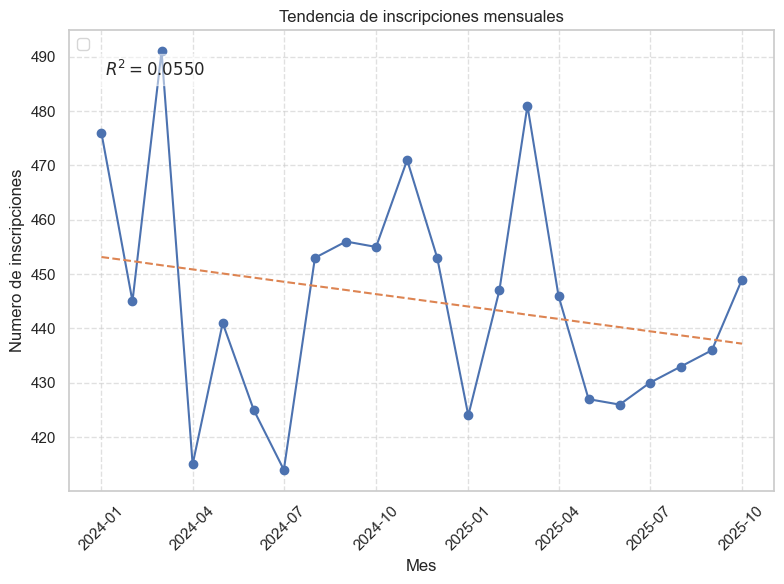

In [146]:
# Convertimos la columna de fechas de registro a un formato que Python reconozca como tiempo real
df_users["signup_date"] = pd.to_datetime(df_users["signup_date"])

# Agrupa por mes, cuenta registros y ordena cronológicamente
signup_MOM = df_users["signup_date"].dt.to_period("M").value_counts().sort_index()

# Filtra datos anteriores a noviembre 2025 para evitar meses incompletos
signup_MOM = signup_MOM[signup_MOM.index < "2025-11-01"]

# Convierte periodos a timestamps para que sean compatibles con el eje X del gráfico
signup_MOM_indice = signup_MOM.index.to_timestamp()

# Prepara los ejes: x_vals como secuencia numérica y y_vals como conteos
x_vals = np.arange(len(signup_MOM))
y_vals = signup_MOM.values

# Calcula la línea de tendencia (regresión lineal de grado 1)
z = np.polyfit(x_vals, y_vals, 1)
p = np.poly1d(z)
y_pred = p(x_vals)

# Calcula el coeficiente $R^2$ para medir la precisión de la tendencia
r2 = r2_score(y_vals, y_pred)

# Grafico
plt.figure(figsize=(8, 6))
ax = plt.gca()

ax.plot(signup_MOM_indice, y_vals, marker="o")
ax.plot(signup_MOM_indice, y_pred, linestyle="--")

ax.text(0.05, 0.9, f'$R^2 = {r2:.4f}$', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.title("Tendencia de inscripciones mensuales")
plt.xlabel("Mes")
plt.ylabel("Numero de inscripciones")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

*Viendo el R2 podemos decir, no con mucha fidelidad (R2 0.055) por el tipo de datos, que a través del tiempo los signups tenderán a disminuir con el tiempo.*

### **Analisis de eventos**

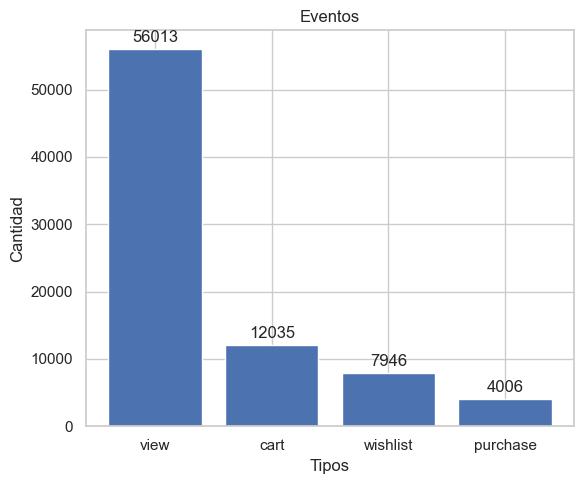

In [147]:
# Cuenta la frecuencia de cada tipo de evento en el dataset
event_counts = df_events["event_type"].value_counts()

plt.figure(figsize=(6,5))
bars = plt.bar(event_counts.index.astype(str), event_counts.values)
plt.title("Eventos")
plt.xlabel("Tipos")
plt.ylabel("Cantidad")
plt.bar_label(bars, padding=3)
plt.tight_layout()
plt.show()

In [148]:
# Union de tablas de events y productos para mejor analisis
df_events_products = df_events.merge(df_products, how="left")

In [149]:
# Se crea una vista para las 2 categorias de productos mas vistas
df_views = df_events_products[df_events_products['event_type'] == 'view']
categoria_mas_vista = df_views.groupby('Category').size().sort_values(ascending=False)
print("Las categorias mas vistas son:")
print(categoria_mas_vista.head(3),"\n")
print("---"*10)

# Se crea una vista para las 2 categorias de productos mas compradas
df_purchase = df_events_products[df_events_products['event_type'] == 'purchase']
categoria_mas_comprada = df_purchase.groupby('Category').size().sort_values(ascending=False)
print("\nLas categorias mas compradas son:")
print(categoria_mas_comprada.head(3))

Las categorias mas vistas son:
Category
Beauty & Hygiene            23605
Foodgrains, Oil & Masala     8124
Eggs, Meat & Fish            5694
dtype: int64 

------------------------------

Las categorias mas compradas son:
Category
Beauty & Hygiene            1681
Foodgrains, Oil & Masala     587
Eggs, Meat & Fish            407
dtype: int64


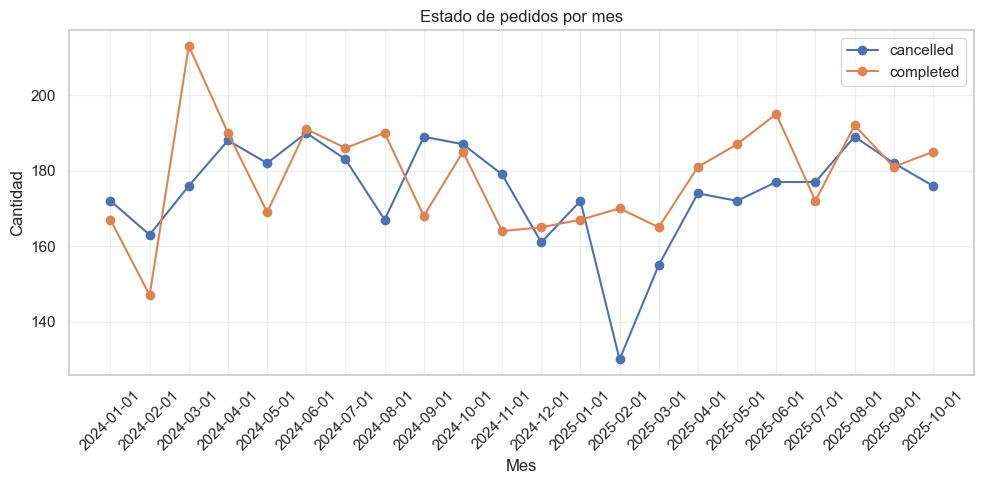

In [150]:
# Definimos los estados de interés y filtramos el DataFrame original
estados = ['completed', 'cancelled']
df_filtrado = df_orders[df_orders['order_status'].isin(estados)].copy()
df_filtrado['order_date'] = pd.to_datetime(df_filtrado['order_date'])
df_monthly = df_filtrado.groupby([df_filtrado['order_date'].dt.to_period('M'), 'order_status']).size().unstack(fill_value=0)
df_monthly = df_monthly[df_monthly.index < "2025-11-01"]
df_monthly.index = df_monthly.index.to_timestamp()

plt.figure(figsize=(10, 5))
df_monthly.index = df_monthly.index.astype(str)
for status in df_monthly.columns:
    plt.plot(df_monthly.index, df_monthly[status], marker='o', label=status)
plt.title(f"Estado de pedidos por mes")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Se comparan 2 estados de pedidos, se puede ver que hay meses donde los pedidos tienen mayor numero de estados cancelados que completados, lo cual puede significar perdidas de ganancias en la compañia, se sugiere una revision operacional en el tema de envios de los productos y mejorar los tiempos de entrega*

### **Analisis de ganancias**

In [151]:
df_order_items

,order_item_id,order_id,product_id,user_id,quantity,item_price,total_price
0,I00000001,O00000001,P001758,U009310,2,1650,3300
1,I00000002,O00000001,P001119,U009310,1,1550,1550
2,I00000003,O00000001,P001794,U009310,1,1750,1750
3,I00000004,O00000001,P001038,U009310,1,4350,4350
4,I00000005,O00000002,P000859,U003247,1,1400,1400
...,...,...,...,...,...,...,...
43520,I00043521,O00019999,P001684,U006170,1,2500,2500
43521,I00043522,O00020000,P001940,U009938,3,3990,11970
43522,I00043523,O00020000,P000221,U009938,3,100,300
43523,I00043524,O00020000,P000248,U009938,1,700,700


In [152]:
df_orders_products = df_order_items.merge(df_products,how="left")

In [153]:
# Se unen las tablas de order_items y productos para mejor analisis
df_orders_products = df_order_items.merge(df_products,how="left")
revenue =  df_orders_products["total_price"].sum()
average_per_order = df_orders["total_amount"].mean()
print(f"El revenue total es de: ${round(revenue,2)}\n")
print(f"El valor promedio por orden es de: ${round(average_per_order,2)}")

El revenue total es de: $269504890

El valor promedio por orden es de: $13475.24


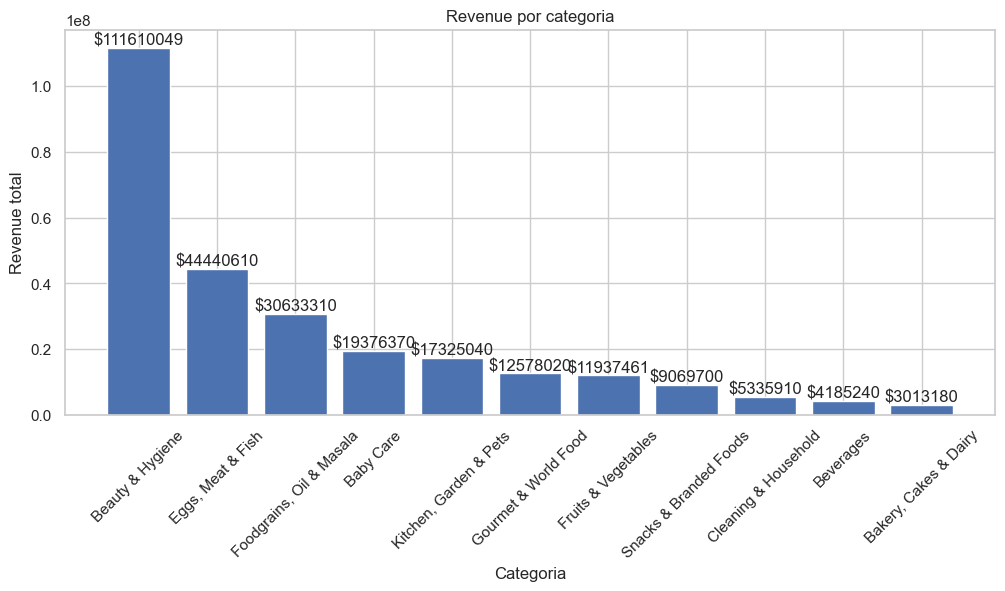

In [154]:
df_revenue_category = df_orders_products.groupby("Category")["total_price"].sum().sort_values(ascending=False)


plt.figure(figsize=(12, 5))
bars = plt.bar(df_revenue_category.index, df_revenue_category.values)
plt.bar_label(bars, fmt='$%.0f')
plt.title("Revenue por categoria")
plt.xlabel("Categoria", fontsize=12)
plt.ylabel("Revenue total", fontsize=12)
plt.xticks(rotation=45)
plt.show()


### **Analisis de rating**

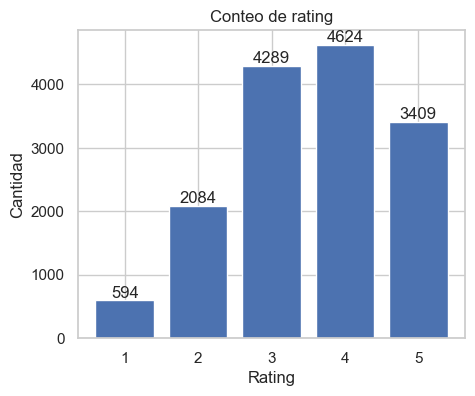

In [155]:
plt.figure(figsize=(5, 4))
bars = plt.bar(df_reviews["rating"].value_counts().index, df_reviews["rating"].value_counts().values)
plt.bar_label(bars)
plt.title("Conteo de rating")
plt.xlabel("Rating")
plt.ylabel("Cantidad")
plt.show()

### **Ratings negativos por mes con linea de coefeciente de determinacion**

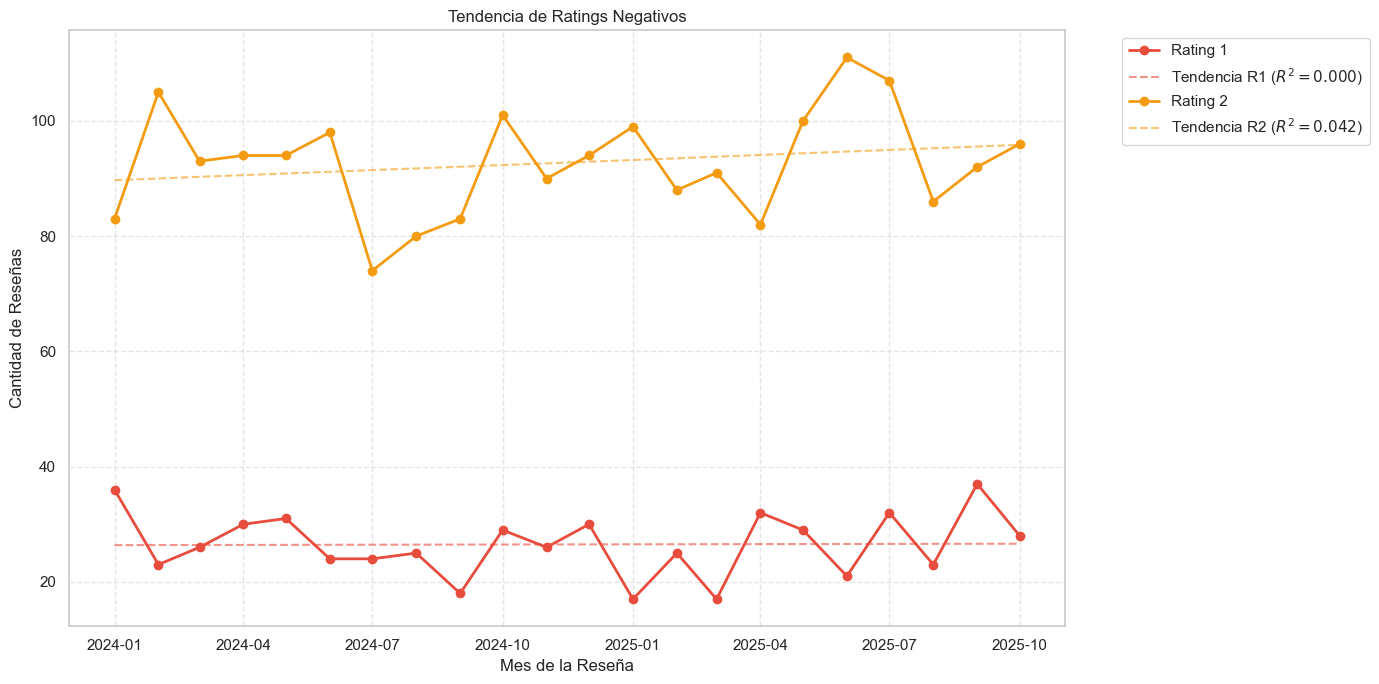

In [156]:
ratings = [1, 2]
df_ratings_negativos = df_reviews[df_reviews["rating"].isin(ratings)].copy()
df_ratings_negativos["review_date"] = pd.to_datetime(df_ratings_negativos["review_date"])

df_ratings_negativos = df_ratings_negativos[df_ratings_negativos["review_date"] < "2025-11-01"]

df_monthly_neg_ratings = df_ratings_negativos.groupby([
    df_ratings_negativos["review_date"].dt.to_period("M"), 
    "rating"
]).size().unstack(fill_value=0)

df_monthly_neg_ratings.index = df_monthly_neg_ratings.index.to_timestamp()

plt.figure(figsize=(14, 7))
ax = plt.gca()
colors = {1: '#e74c3c', 2: '#f39c12'}
x_vals = np.arange(len(df_monthly_neg_ratings))

for rating in ratings:
    y_vals = df_monthly_neg_ratings[rating].values
    ax.plot(df_monthly_neg_ratings.index, y_vals, marker='o', label=f'Rating {rating}', color=colors[rating], linewidth=2)
    
    z = np.polyfit(x_vals, y_vals, 1)
    p = np.poly1d(z)
    y_pred = p(x_vals)
    r2 = r2_score(y_vals, y_pred)
    
    ax.plot(df_monthly_neg_ratings.index, y_pred, linestyle='--', color=colors[rating], alpha=0.6, 
            label=f'Tendencia R{rating} ($R^2 = {r2:.3f}$)')

plt.title('Tendencia de Ratings Negativos')
plt.xlabel('Mes de la Reseña', fontsize=12)
plt.ylabel('Cantidad de Reseñas', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

*Los ratings nivel 1 no siguen un patrón y son aleatorios. Sin embargo, los ratings nivel 2 muestran una tendencia al alza, lo que indica que el descontento leve de los clientes está creciendo poco a poco*

In [157]:
df_reviews_productos = df_reviews.merge(df_products, how="left")
df_negativos = df_reviews_productos[df_reviews_productos["rating"].isin([1, 2])]
reporte_negativo = (df_negativos.groupby(["rating", "Category"]).size().sort_values(ascending=False).groupby(level=0).head(2))

print("\nSe muestra el nivel 1 y 2 junto a sus 2 categorias mas afectadas\n")
print("--"*30)
print(reporte_negativo)


Se muestra el nivel 1 y 2 junto a sus 2 categorias mas afectadas

------------------------------------------------------------
rating  Category                
2       Beauty & Hygiene            883
        Foodgrains, Oil & Masala    301
1       Beauty & Hygiene            247
        Foodgrains, Oil & Masala     92
dtype: int64


### **Analisis de ordenes y productos**

In [158]:
df_orders_final = df_order_items.merge(df_orders, how="left")
df_orders_final.groupby("order_status").size()

order_status
cancelled     8593
completed     8733
processing    8458
returned      8802
shipped       8939
dtype: int64

*Se evidencia normailidad en todos los estados de las ordenes*

In [159]:
print("Facturas:", df_orders_final["order_id"].nunique())
print("Cantidad de productos en las facturas:", df_orders_final["order_item_id"].nunique())
print("Productos disponibles:", df_orders_final["product_id"].nunique())

Facturas: 20000
Cantidad de productos en las facturas: 43525
Productos disponibles: 2000


*Vista preliminar variables a utilizar en modelos de recomendacion*

In [160]:
items_per_order = (df_orders_final.groupby("order_id")["product_id"].count())
items_per_order.describe()

count    20000.000000
mean         2.176250
std          1.232989
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: product_id, dtype: float64

*Ya que la media es mayor a uno, es viable usar modelos de asociacion como "Apriori"*

___

#### **Evaluación de la calidad de datos**

In [161]:
# evaluar la viabilidad técnica del sistema
print("\nREPORTE DE VIABILIDAD TÉCNICA (SVD vs NLP)")
print("---" * 30)

# Forzamos todo a minúsculas para evitar KeyErrors
df_products.columns = [c.lower() for c in df_products.columns]
df_users.columns = [c.lower() for c in df_users.columns]
# ---------------------------------------------------

# -------------------------------------------------------------------------
# A. EVALUACIÓN PARA FILTRADO COLABORATIVO (SVD)
# Factor Crítico: Sparsity (¿Tenemos suficientes interacciones?)
# -------------------------------------------------------------------------
print("\n1. DIAGNÓSTICO MODELO SVD (Patrones de Compra)")

# 1. Definir dimensiones del espacio
n_users = df_users['user_id'].nunique()
# Buscamos 'product_id' o 'id'
col_id_prod = 'product_id' if 'product_id' in df_products.columns else 'id'

n_products = df_products[col_id_prod].nunique()
total_celdas = n_users * n_products

# 2. Contar interacciones reales (Señal)
n_interacciones = df_order_items.shape[0] + df_reviews.shape[0]

# 3. Calcular Métricas
sparsity = 1 - (n_interacciones / total_celdas)
# Evitar división por cero
if total_celdas > 0:
    density = (n_interacciones / total_celdas) * 100
else:
    sparsity = 1.0
    density = 0.0

print(f"   - Matriz Potencial: {n_users} usuarios x {n_products} productos")
print(f"   - Señales (Ventas+Reviews): {n_interacciones}")
print(f"   - Dispersión (Sparsity): {sparsity:.4%}")

if sparsity > 0.995:
    estado_svd = "RIESGO ALTO"
    print(f"   CONCLUSIÓN: {estado_svd}. Matriz muy vacía.")
    print("      El modelo SVD tendrá dificultades para generalizar (Cold Start severo).")
else:
    estado_svd = "OPTIMO"
    print(f"   CONCLUSIÓN: {estado_svd}. Densidad saludable para detectar patrones.")

# -------------------------------------------------------------------------
# B. EVALUACIÓN PARA BASADO EN CONTENIDO (NLP)
# Factor Crítico: Riqueza Semántica (¿Tenemos suficiente texto para diferenciar?)
# -------------------------------------------------------------------------
print("\n2. DIAGNÓSTICO MODELO NLP (Similitud de Texto)")

# 1. Simular la creación del perfil ('Soup')
# Intentamos detectar las columnas de texto disponibles
cols_disponibles = [c for c in ['brand', 'category', 'productname', 'name'] if c in df_products.columns]

if not cols_disponibles:
    print("   Error: No se encontraron columnas de texto (brand, category, productname).")
    estado_nlp = "CRÍTICO"
else:
    temp_df = df_products[cols_disponibles].fillna('')
    # Concatenar todas las columnas encontradas
    perfil_simulado = temp_df.apply(lambda x: ' '.join(x.astype(str)), axis=1)

    # 2. Calcular Estadísticas de Texto
    promedio_caracteres = perfil_simulado.str.len().mean()
    registros_vacios = perfil_simulado[perfil_simulado.str.len() < 5].count()
    duplicados_texto = perfil_simulado.duplicated().sum()

    print(f"   - Columnas usadas: {cols_disponibles}")
    print(f"   - Longitud promedio de descripción: {promedio_caracteres:.1f} caracteres")
    print(f"   - Productos sin descripción útil: {registros_vacios} ({(registros_vacios/len(df_products)):.1%})")
    print(f"   - Descripciones duplicadas: {duplicados_texto} ({(duplicados_texto/len(df_products)):.1%})")

    if promedio_caracteres > 15 and duplicados_texto < (len(df_products) * 0.2):
        estado_nlp = "ROBUSTO"
        print(f"   CONCLUSIÓN: {estado_nlp}. Hay suficiente texto distintivo para vectorizar.")
    else:
        estado_nlp = "DÉBIL"
        print(f"   CONCLUSIÓN: {estado_nlp}. Los metadatos son pobres o repetitivos.")

# -------------------------------------------------------------------------
# C. ESTRATEGIA FINAL DEL EQUIPO
# -------------------------------------------------------------------------
print("---" * 30)
print("DECISIÓN DE ARQUITECTURA:")

if estado_svd == "RIESGO ALTO" and estado_nlp == "ROBUSTO":
    print("   Priorizar NLP como motor principal. Usar SVD solo como complemento secundario.")
elif estado_svd == "OPTIMO" and estado_nlp == "ROBUSTO":
    print("   Escenario ideal para Sistema Híbrido Ponderado (50% SVD / 50% NLP).")
else:
    print("   Se requiere enriquecer la data (Data Augmentation) antes de modelar.")


REPORTE DE VIABILIDAD TÉCNICA (SVD vs NLP)
------------------------------------------------------------------------------------------

1. DIAGNÓSTICO MODELO SVD (Patrones de Compra)
   - Matriz Potencial: 10000 usuarios x 2000 productos
   - Señales (Ventas+Reviews): 58525
   - Dispersión (Sparsity): 99.7074%
   CONCLUSIÓN: RIESGO ALTO. Matriz muy vacía.
      El modelo SVD tendrá dificultades para generalizar (Cold Start severo).

2. DIAGNÓSTICO MODELO NLP (Similitud de Texto)
   - Columnas usadas: ['brand', 'category', 'productname']
   - Longitud promedio de descripción: 76.0 caracteres
   - Productos sin descripción útil: 0 (0.0%)
   - Descripciones duplicadas: 0 (0.0%)
   CONCLUSIÓN: ROBUSTO. Hay suficiente texto distintivo para vectorizar.
------------------------------------------------------------------------------------------
DECISIÓN DE ARQUITECTURA:
   Priorizar NLP como motor principal. Usar SVD solo como complemento secundario.
